In [1]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
from matplotlib import pyplot as plt
from scipy.stats import fisher_exact, hypergeom
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA, NMF
from sklearn.preprocessing import StandardScaler
import pickle
import scipy.spatial
# import networkx as nx
import seaborn as sns
import anndata
import scanpy as sc

In [2]:
# tissue = 'ob'
tissue = 'cortex_svz'

In [3]:
df = pd.read_csv(f'../original_files/sourcedata/{tissue}_counts.csv')
gene_name = df.columns.values
expression = df.values
print(expression.shape)
del df

(913, 10000)


In [4]:
df = pd.read_csv(f'../original_files/sourcedata/{tissue}_cellcentroids.csv')
df_ann = pd.read_csv(f'../original_files/celltype_annotations/{tissue}_cell_type_annotations.csv')
df = pd.concat([df, df_ann['louvain']], axis=1)
del df_ann
print(df.shape)
print(df.columns)
df_group = df.groupby('Field of View', axis=0)
print(len(df_group))

(913, 6)
Index(['Field of View', 'Cell ID', 'X', 'Y', 'Region', 'louvain'], dtype='object')
7


In [5]:
df.groupby('louvain').size()

louvain
1     99
2     68
3     55
4     53
5     51
6     48
7     42
8     40
9     39
10    38
11    37
12    36
13    29
14    28
15    28
16    26
17    26
18    25
19    24
20    23
21    21
22    20
23    18
24    17
25    15
26     7
dtype: int64

# = 2470
cortex_n0_0.4


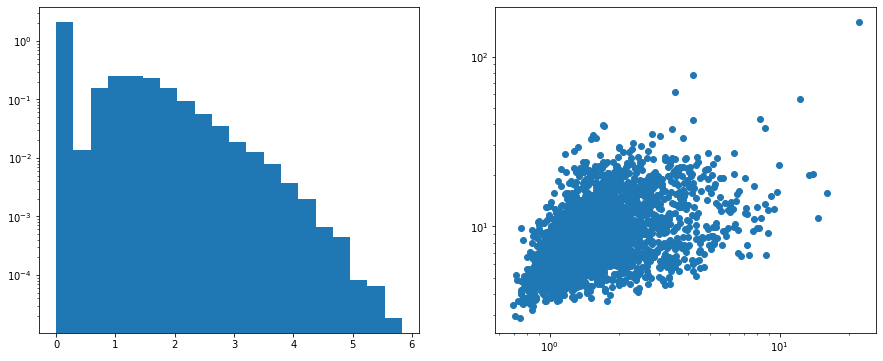

In [7]:
nonzero_threshold = .4
gene_str = f'cortex_n0_{nonzero_threshold:.1f}'
gene_idx = (expression[df['Field of View'].values < 5] != 0).mean(0) > nonzero_threshold
print(f'# = {gene_idx.sum()}')

expr_processed = expression / expression.sum(1, keepdims=True) * 1e4
expr_processed = np.log1p(expr_processed)
# expr_processed = np.log1p(expr_norm)
# gene_str += '_NormPerCell1e4'
print(gene_str)

fig, axes = plt.subplots(1, 2, figsize=(15, 6))
axes[0].hist(expr_processed[:, gene_idx].ravel(), density=True, bins=20)
axes[0].set_yscale('log')
avg = np.expm1(expr_processed[:, gene_idx]).mean(0)
var = np.expm1(expr_processed[:, gene_idx]).var(0)
# avg = expression[:, gene_idx].mean(0)
# std = expression[:, gene_idx].std(0)
axes[1].scatter(avg, var/avg)
axes[1].set_xscale('log')
axes[1].set_yscale('log')

In [8]:
df.groupby(['Field of View', 'Region']).size()

Field of View  Region        
0              Cortex            118
1              Cortex            108
2              Cortex             90
3              Cortex            106
4              Cortex            101
5              Cortex              1
               SVZ               280
6              Choroid Plexus    109
dtype: int64

In [11]:
Es = []
# neighbor_method_str = 'KNN graph'
neighbor_method_str = 'Delaunay'
if neighbor_method_str == 'KNN graph':
    radius = 40
    n_neighbors = 5
    neighbor_str = f'r{radius}_n{n_neighbors}'
elif neighbor_method_str == 'Delaunay':
    radius = 300
    neighbor_str = f'Delaunay_r{radius}'
else:
    assert False
for key, d in df_group:
    X = d[['X', 'Y']].values
    if neighbor_method_str == 'KNN graph':
        nbrs = sklearn.neighbors.NearestNeighbors(
            n_neighbors=n_neighbors,
            radius=radius,
            metric='euclidean',
        ).fit(X)
    #     dists, E = nbrs.radius_neighbors(X)
        dist, E = nbrs.kneighbors()
        E = [[v for d, v in zip(disti, Ei) if d <= radius] for disti, Ei in zip(dist, E)]
        E = [set(list(e)) for e in E]
        for u, Eu in enumerate(E):
            for v in Eu:
                E[v] |= {u}
    elif neighbor_method_str == 'Delaunay':
        E = [set() for _ in X]
        tri = scipy.spatial.Delaunay(X)
        for simplex in tri.simplices:
            simplex = set(list(simplex))
            for u in simplex:
                E[u] |= simplex
        for u in range(len(X)):
            E[u] -= {u}
            E[u] = set([v for v in E[u] if np.linalg.norm(X[u] - X[v]) <= radius])
    else:
        assert False
    Es.append(E)
    assert all(i in E[j] for i, e in enumerate(E) for j in e)
    l = np.array(list(map(len, E)))
    print(
        f'min = {l.min()}, mean = {l.mean():.1f}, median = {np.median(l)}, max = {l.max()}; '
        f'# = {len(X)}, #0 = {(l==0).sum()}')

min = 0, mean = 5.2, median = 5.0, max = 8; # = 118, #0 = 1
min = 1, mean = 5.0, median = 5.0, max = 8; # = 108, #0 = 0
min = 1, mean = 4.9, median = 5.0, max = 8; # = 90, #0 = 0
min = 1, mean = 5.1, median = 5.0, max = 8; # = 106, #0 = 0
min = 1, mean = 5.1, median = 5.0, max = 8; # = 101, #0 = 0
min = 2, mean = 5.7, median = 6.0, max = 9; # = 281, #0 = 0
min = 1, mean = 5.0, median = 5.0, max = 8; # = 109, #0 = 0


In [8]:
with open(f'../files/genes_{gene_str}.txt', 'w') as f:
    for g in gene_name[gene_idx]: f.write(g + '\n')
with open(f'../files/genes_all.txt', 'w') as f:
    for g in gene_name: f.write(g + '\n')
for (fov, cell_idx), (key, df_fov), E in zip(df_group.groups.items(), df_group, Es):
    print(fov, len(cell_idx))
    with open(f'../files/coordinates_{fov}.pkl', 'wb') as f: pickle.dump(df_fov[['X', 'Y']].values, f)
    with open(f'../files/expression_{fov}_{gene_str}.pkl', 'wb') as f: pickle.dump(expr_processed[cell_idx][:, gene_idx], f)
    with open(f'../files/expression_{fov}_all.pkl', 'wb') as f: pickle.dump(expr_processed[cell_idx], f)
    with open(f'../files/expression_{fov}_raw.pkl', 'wb') as f: pickle.dump(expression[cell_idx], f)
    with open(f'../files/cell_types_{fov}.txt', 'w') as f: f.write('\n'.join(map(str, df_fov['louvain'].tolist())) + '\n')
    d = df_fov[['Field of View', 'X', 'Y', 'Region', 'louvain']].copy()
    d.columns = ['Field of View', 'coor X', 'coor Y', 'Region', 'louvain']
    d.to_csv(f'../files/meta_{fov}.csv')
    with open(f'../files/neighborhood_{fov}_{neighbor_str}.txt', 'w') as f:
        for u, e in enumerate(E):
            for v in e:
                if u >= v: continue
                f.write(f'{u}\t{v}\n')

0 118
1 108
2 90
3 106
4 101
5 281
6 109
